##  RNN-Based Detection

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import pandas as pd
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import sklearn.metrics as metrics

In [143]:
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import one_hot


In [92]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


REPLICAS:  1


In [93]:
train_data= pd.read_csv('/content/drive/MyDrive/matt/Projects/whatsapp/jigsaw-toxic-comment-train.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/matt/Projects/whatsapp/validation.csv')
test_data = pd.read_csv('/content/drive/MyDrive/matt/Projects/whatsapp/test.csv')

In [94]:
train_data.shape

(223549, 8)

In [95]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [96]:
validation_data.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [97]:
test_data.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [98]:
train_data.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [99]:
train_data.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [100]:
train_data["toxic"].value_counts()

,count
toxic,
0,202165
1,21384


In [101]:
train_data= train_data.loc[:15000,:]

In [102]:
train_data.shape

(15001, 3)

In [103]:
train_data["toxic"].value_counts()

,count
toxic,
0,13562
1,1439


In [104]:
train_data.dtypes

,0
id,object
comment_text,object
toxic,int64


##  Visualization

In [105]:
train_data= pd.read_csv('/content/drive/MyDrive/matt/Projects/whatsapp/jigsaw-toxic-comment-train.csv')
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

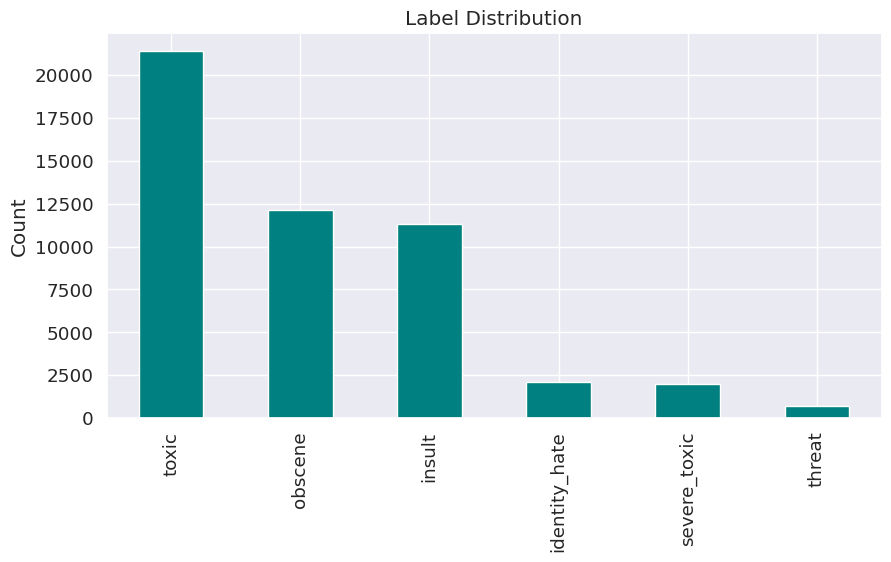

In [106]:
train_data[label_cols].sum().sort_values(ascending=False).plot(kind='bar', color='teal', figsize=(10,5), title='Label Distribution')
plt.ylabel('Count'); plt.show()


In [109]:
train_data['comment_length'] = train_data['comment_text'].astype(str).apply(lambda x: len(x.split()))

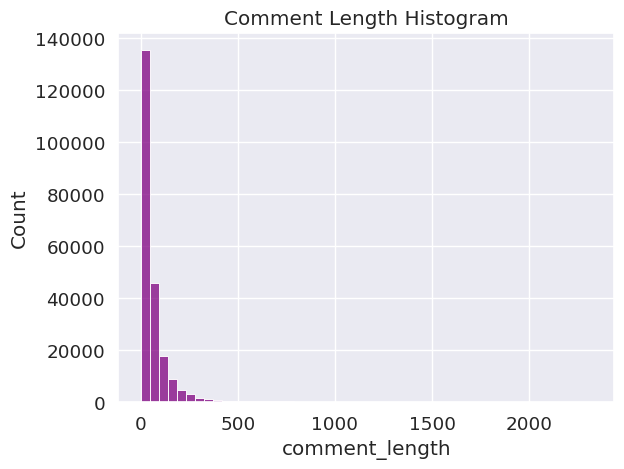

In [110]:
sns.histplot(train_data['comment_length'], bins=50, color='purple')
plt.title('Comment Length Histogram'); plt.show()

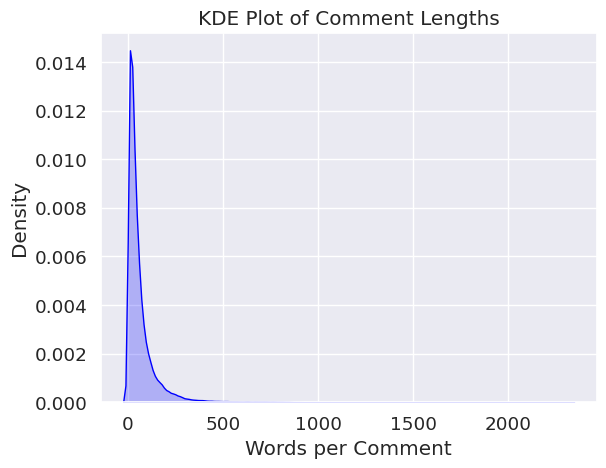

In [111]:
sns.kdeplot(train_data['comment_length'], fill=True, color='blue')
plt.title('KDE Plot of Comment Lengths'); plt.xlabel('Words per Comment'); plt.show()


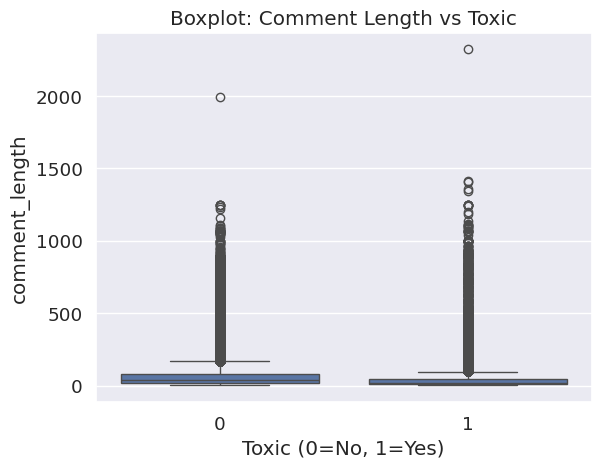

In [112]:
sns.boxplot(x='toxic', y='comment_length', data=train_data)
plt.title('Boxplot: Comment Length vs Toxic'); plt.xlabel('Toxic (0=No, 1=Yes)'); plt.show()

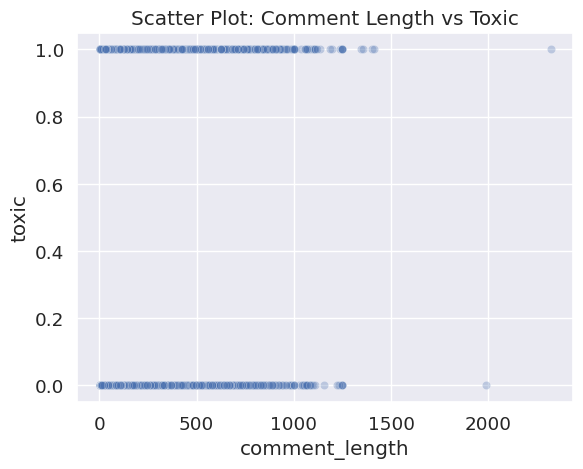

In [113]:
sns.scatterplot(x='comment_length', y='toxic', data=train_data, alpha=0.3)
plt.title('Scatter Plot: Comment Length vs Toxic'); plt.show()

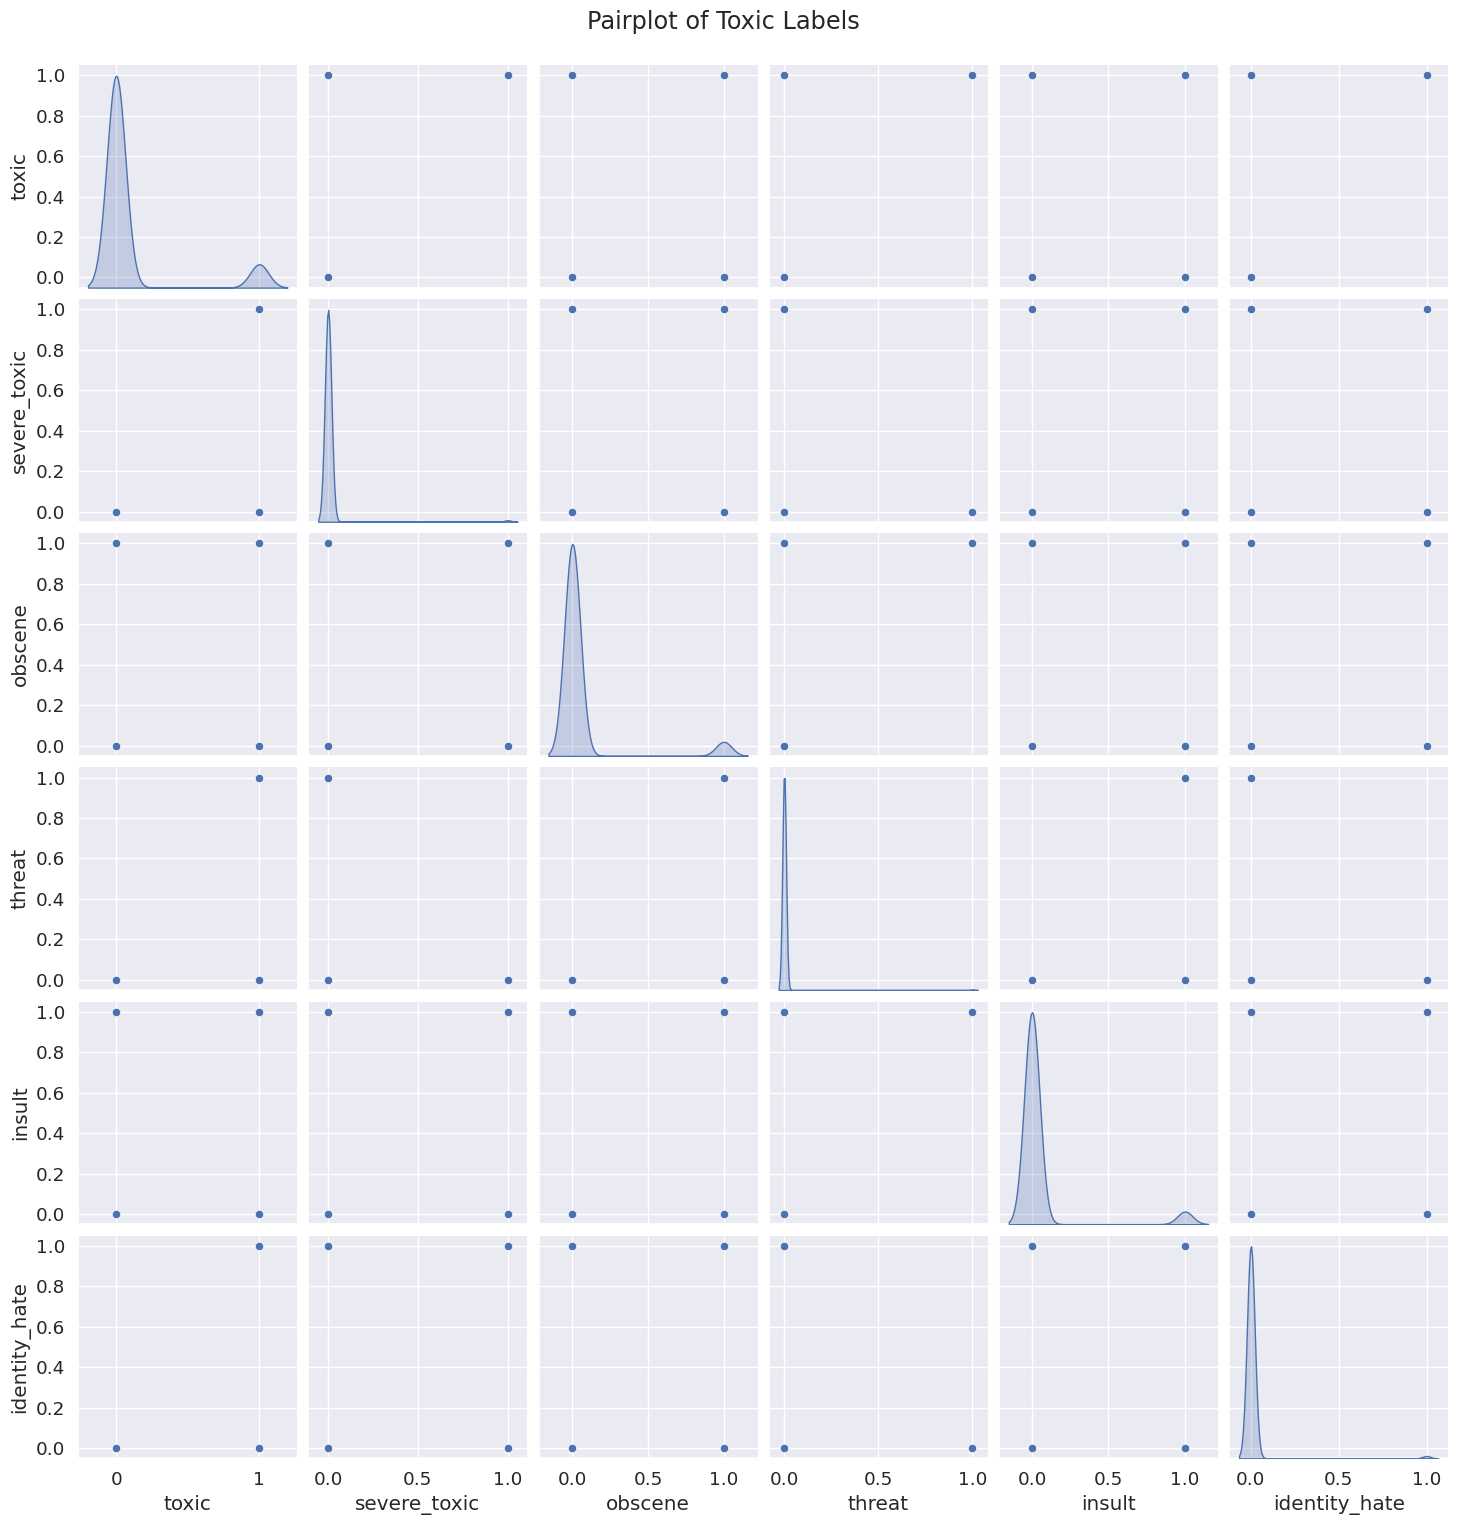

In [114]:
sns.pairplot(train_data[label_cols].sample(2000, random_state=42), diag_kind='kde')
plt.suptitle('Pairplot of Toxic Labels', y=1.02)
plt.show()


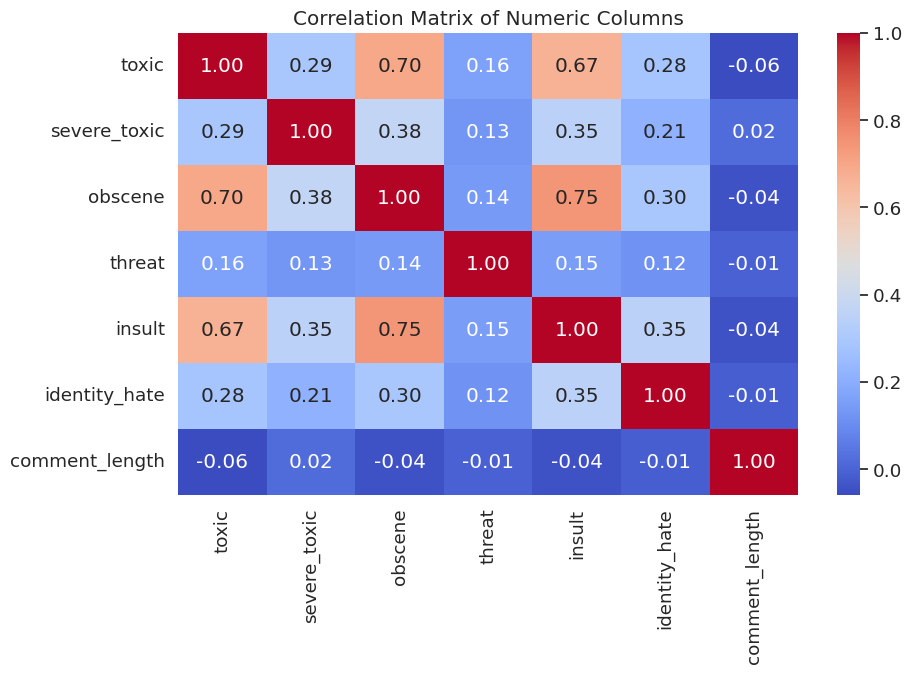

In [115]:
numeric_cols = train_data.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_cols.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Columns")
plt.show()

In [116]:
train_data['comment_text'].apply(lambda x:len(str(x).split())).max()

2321

In [117]:
train_data.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
22329,3ae50e173ac456c0,"""\n\n Semi-protected edit request on 29 Decemb...",0,0,0,0,0,0,42
73686,c52f9c41ad9c0c4f,shetland sheepdogs rule so does KFC can't beat...,0,0,0,0,0,0,10
2862,07b8397904f068f5,Well is seems the proposal isn't attracting an...,0,0,0,0,0,0,14
189468,7734abfc250d7d0b,:::: then the link could be directly to the ph...,0,0,0,0,0,0,11
151154,7820d19b8e08ce40,"""Your behavior 124.176.176.8 is bringing more ...",0,0,0,0,0,0,42


In [118]:
y=train_data["toxic"].values

In [119]:

train_data=train_data["comment_text"].copy()

In [120]:
corpus = []
for i in range(0, len(train_data)):
    review = train_data[i]
    review = review.split()
    review = ' '.join(review)
    corpus.append(review)

In [121]:

voc_size = 20000
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [129]:
sent_length=300
embedded_docs=pad_sequences(onehot_repr,maxlen=sent_length,padding='pre')
print(embedded_docs)

[[    0     0     0 ...  7190 16844 11077]
 [    0     0     0 ... 14666  3713 17396]
 [    0     0     0 ... 18064  8378 14457]
 ...
 [    0     0     0 ...  1848  5250   943]
 [    0     0     0 ...  4369  2891 12208]
 [    0     0     0 ... 15976 12728 13856]]


In [130]:
X_final=np.array(embedded_docs)
Y_final=np.array(y)

In [131]:
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size=0.3, random_state=42,shuffle=True)

In [132]:
features=40

model = Sequential()
model.add(Embedding(voc_size,features,input_length=sent_length))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [135]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=40)

Epoch 1/10
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 496s 126ms/step - accuracy: 0.9234 - loss: 0.2355 - val_accuracy: 0.9450 - val_loss: 0.1661
Epoch 2/10
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 537s 135ms/step - accuracy: 0.9465 - loss: 0.1504 - val_accuracy: 0.9443 - val_loss: 0.1567
Epoch 3/10
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 561s 135ms/step - accuracy: 0.9514 - loss: 0.1373 - val_accuracy: 0.9456 - val_loss: 0.1711
Epoch 4/10
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 563s 135ms/step - accuracy: 0.9513 - loss: 0.1382 - val_accuracy: 0.9446 - val_loss: 0.1796
Epoch 5/10
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 560s 135ms/step - accuracy: 0.9591 - loss: 0.1152 - val_accuracy: 0.9375 - val_loss: 0.1741
Epoch 6/10
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 563s 135ms/step - accuracy: 0.9619 - loss: 0.1075 - val_accuracy: 0.9355 - val_loss: 0.1989
Epoch 7/10
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 560s 134ms/step - accuracy: 0.9584 - loss: 0.1145 - val_accuracy: 0.9437 - val_loss: 0.1695
Epoch 8/10
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 565s 135ms/step - ac

In [137]:
y_pred=(model.predict(X_test) > 0.5).astype("int32")


2096/2096 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step


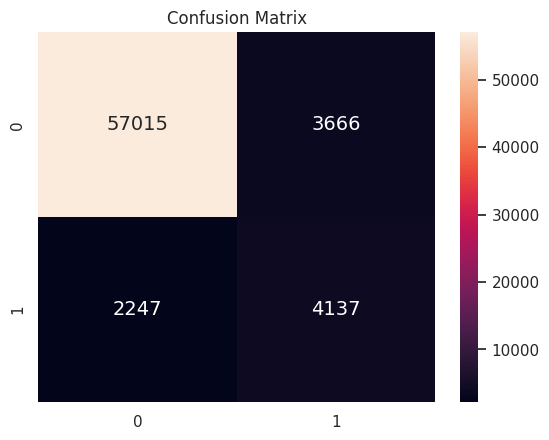

In [138]:
cm = confusion_matrix(Y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True, annot_kws={'size':14}, fmt='d').set_title('Confusion Matrix')
plt.show()

In [139]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     60681
           1       0.53      0.65      0.58      6384

    accuracy                           0.91     67065
   macro avg       0.75      0.79      0.77     67065
weighted avg       0.92      0.91      0.92     67065



In [140]:
x = ["the most illiterate ,ill manared,psychopath just barks whatever shit out of his mouth"]
voc_size = 2000
sent_length = 20


onehot_repr = [one_hot(sentence, voc_size) for sentence in x]
embedded_docs = pad_sequences(onehot_repr, maxlen=sent_length, padding='pre')
X_input = np.array(embedded_docs)

prediction = (model.predict(X_input) > 0.5).astype(int)
print("toxic" if prediction == 1 else "non toxic")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
non toxic


In [159]:
import joblib
joblib.dump(model,'/content/drive/MyDrive/matt/Projects/whatsapp/toxic_comment_model.keras')
print(" Model saved")


 Model saved


In [166]:
loaded_model = joblib.load('/content/drive/MyDrive/matt/Projects/whatsapp/toxic_comment_model.keras')
print("Model loaded")


Model loaded
